In [1]:
import ee
ee.Initialize ()

In [2]:
from iteru import *
from IPython.display import display
import ipywidgets
import datetime

In [3]:
Map = Map()
Map

Map(center=[27, 31], controls=(SearchControl(found_style={'fillColor': '#3f0', 'color': '#0f0'}, marker=Marker…

In [73]:
aoi = GERD_aoi

In [116]:
start_year = 2020
start_month = 1
start_day = 1
end_year = 2022
end_month = 3
end_day = 12
time_delta = 30
water_threshold = -25.5

In [117]:
start_date = datetime.date(start_year,start_month,start_day)
end_date = datetime.date(end_year,end_month,end_day)
ee_start_date = f'{start_year}-{start_month}-{start_day}'
ee_end_date = f'{end_year}-{end_month}-{end_day}'

In [118]:
dates_list = get_dates_sequence(start_date ,end_date, time_delta)

In [143]:
SAR = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.equals('relativeOrbitNumber_start', 50))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.eq('resolution_meters',10))\
    .filterBounds(aoi)\
    .filterDate(ee_start_date,ee_end_date)\
    .select(['VV','VH'])

In [144]:
SAR = SAR.map(addRatioBand)

In [145]:
def filterSpeckles(img):
    
    VV_smooth = img.select('VH').focal_median(100,'circle','meters').rename('VH_Filtered')
    
    return img.addBands(VV_smooth)

In [146]:
# def apply_RefinedLee(img):
    
#     VH_Filtered = ee.Image(toDB(RefinedLee(toNatural(img.select(['VH']))))).rename('VH_Filtered')
    
#     return img.addBands(VH_Filtered)

In [147]:
SAR = SAR.map(filterSpeckles)

In [148]:
# SAR = SAR.map(apply_RefinedLee)

In [149]:
# def addOtsuThreshold(img):
    
#     histogram = img.select('VH_Filtered').reduceRegion(               
#             reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
#             geometry = aoi, 
#             scale = 10,
#             bestEffort = True  
#                               )
#     otsu_threshold = otsu(histogram.get('VH_Filtered_histogram'))
    
#     water_mask = img.select('VH_Filtered').lt(otsu_threshold).selfMask().rename('water_mask')
    
#     water_mask = water_mask.set({"otsu_threshold": otsu_threshold})
    
#     return img.addBands(water_mask)
      

In [150]:
# SAR = SAR.map(addOtsuThreshold)

In [151]:
def water_classify_threshold(col, threshold):
    
    
    def water_classify(img):
        
        VH_Filtered  = img.select('VH_Filtered')
        water = VH_Filtered.lt(threshold).rename('Water')
        water_mask = water.updateMask(water).rename('water_mask')
        
        return img.addBands([water,water_mask])
    
    return col.map(water_classify)
    

In [152]:
SAR = water_classify_threshold(SAR, threshold = -24)

In [153]:
# def rgb_w_water_mask(img):
    
#     img_rgb = img.visualize(**{'min':[-25,-25,0],'max':[0,0,2],'bands':['VV','VH','VV/VH']})
    
#     water_vis = img.select('Water_mask').visualize(**{'min': 0.5,'max': 1,'palette': ['00FFFF', '0000FF']})
                  
#     mosaic = ee.ImageCollection([img_rgb,water_vis]).mosaic()
 
#     return mosaic.copyProperties(img, img.propertyNames())


In [154]:
# SAR = SAR.map(rgb_w_water_mask)

In [155]:
# Map.add_layer_widgets(SAR,{'bands':'VV_Filtered_median','min':-25,'max':5},'TEST_SAR')

In [156]:
# Map.add_layer_widgets(z,{'bands':'Water_mask_median','palette': ['00FFFF', '0000FF']},'TEST_SAR_WATER_MASK')

In [157]:
# Map.add_layer_widgets(SAR,{'min':[-25,-25,0],'max':[0,0,2],'bands':['VV','VH','VV/VH']},'SAR')

In [158]:
def get_images(day_date):
    
    start_day = ee.Date(day_date)
    end_day = start_day.advance(time_delta,'day')
    
    return SAR.filterDate(start_day,end_day).median()\
          .set({'start_day':start_day.format('YYYY-MM-dd')})\
          .set({'end_day':end_day.format('YYYY-MM-dd')})

In [159]:
images = ee.List(dates_list).map(get_images)

In [160]:
collection = ee.ImageCollection.fromImages(images)

In [161]:
# z = collection.filter(ee.Filter.eq('start_day','2021-08-25'))

In [162]:
videoArgs = {
  'dimensions': 900 ,
  'region': aoi,
  'framesPerSecond':2,
  'crs': 'EPSG:3857',
#   'min':[-25,-25,0],
#   'max':[0,0,5],
#   'bands':['VV','VH','VV/VH']
#   'min':[-25],
#   'max':[0],
#   'bands':['VV']
  'bands':['water_mask'],
  'palette': ['00FFFF', '0000FF'],
#   'palette':None,
#   'min':[0.5],
#     'max':[1],
#   'bands':['vis-red','vis-green','vis-blue'],
#    'min':0,
#    'max':255
   
     }

In [163]:
url = collection.getVideoThumbURL(videoArgs)

In [164]:
out_gif = get_gif(url)

In [165]:
add_text_to_gif(out_gif,dates_list, dates_font_size = 25, dates_font_color = 'white', framesPerSecond = 2 )

'C:\\Users\\muham\\AppData\\Local\\Temp\\TimeSeries_DKD.gif'

In [166]:
display_gif(out_gif)

Output()

In [167]:
def calc_area(feature):
    
    area = feature.geometry().area(maxError = 1)
    
    return feature.set({'Area':area})

In [168]:
def water_to_vector(img):
    
    water_mask = img.select('water_mask').clip(aoi)
    
    feature = ee.Image(1).updateMask(water_mask).reduceToVectors(
           geometry = water_mask.geometry(),
           crs ='EPSG:32636',
           scale = 10 , 
           geometryType = 'polygon',
           eightConnected = False,
           labelProperty =  'water_cover',
           bestEffort = True
          )
    feature = feature.map(calc_area)
    
    lake_feature = feature.sort('Area', False).first()
    
    lake_area = lake_feature.geometry().area(maxError = 1) 
    
    return ee.FeatureCollection(lake_feature).set({'Area':lake_area})\
           .copyProperties(img, img.propertyNames())\
           .copyProperties(lake_feature, lake_feature.propertyNames())
    

In [169]:
water_vectors = collection.map(water_to_vector)

In [170]:
# water_vectors = SAR.map(water_to_vector)

In [171]:
water_area = [area /(1e6) for area in water_vectors.aggregate_array('Area').getInfo()]

In [172]:
import matplotlib.pyplot as plt

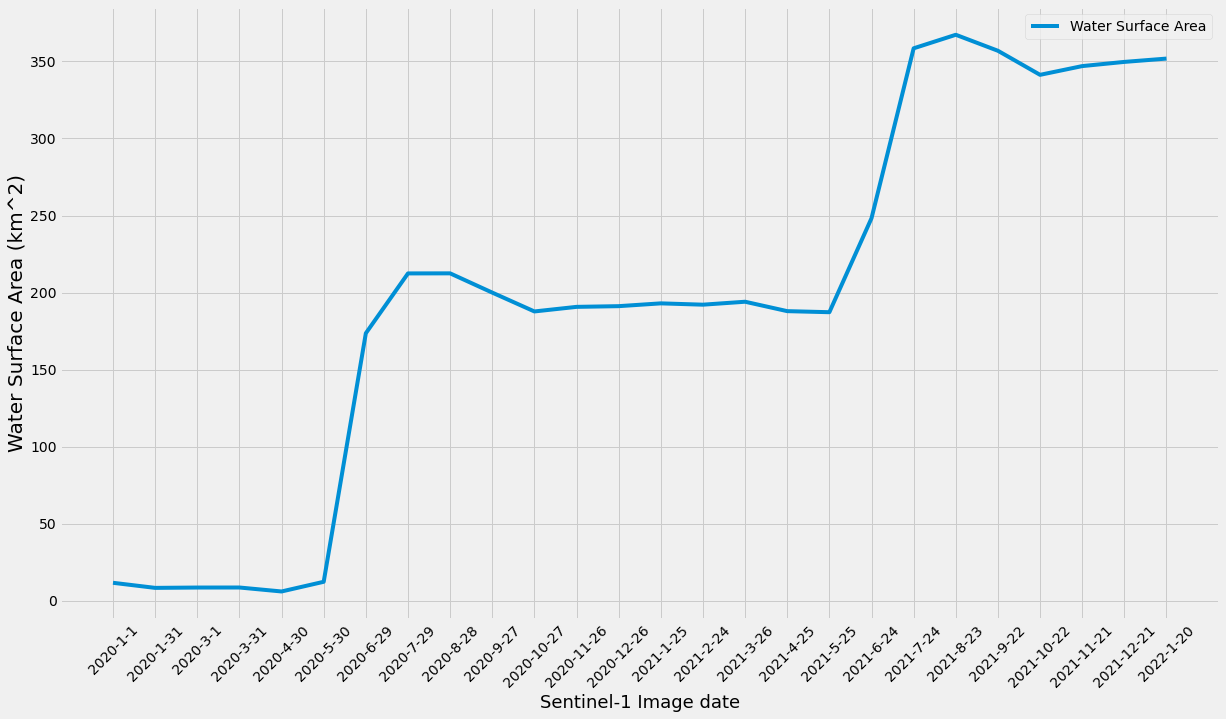

In [173]:
plt.style.use('fivethirtyeight')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.xlabel('Sentinel-1 Image date',fontsize=18)
plt.ylabel('Water Surface Area (km^2)',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.plot(dates_list,water_area,label ='Water Surface Area')
plt.legend()
plt.gcf().set_size_inches(18.5,10.5)

In [174]:
elevation_dataset = ee.ImageCollection('JAXA/ALOS/AW3D30/V3_2')\
           .filter(ee.Filter.bounds(aoi))\
           .select('DSM')\
           .median()\
           .clip(aoi)\
           .reproject(crs = 'EPSG:32636', scale = 30 )

In [175]:
def max_water_ele(feature):
    
    lake_dem = elevation_dataset.clip(feature)
    
    max_ele = lake_dem.reduceRegion(
                         reducer = ee.Reducer.max(),
                         geometry = lake_dem.geometry(), 
                         scale = 30, 
                         crs = 'EPSG:32636',
                        maxPixels = 1e11).get('DSM')
    return lake_dem.set({'Maximum_water_elevation':max_ele,'Image_date':feature.get('start_day')})
    

In [176]:
dems = water_vectors.map(max_water_ele)

In [177]:
max_elev = [elev for elev in dems.aggregate_array('Maximum_water_elevation').getInfo()]

In [178]:
max_elev

[553,
 547,
 548,
 547,
 537,
 541,
 579,
 584,
 585,
 582,
 583,
 587,
 592,
 587,
 594,
 593,
 586,
 581,
 587,
 600,
 600,
 598,
 598,
 598,
 598,
 600]

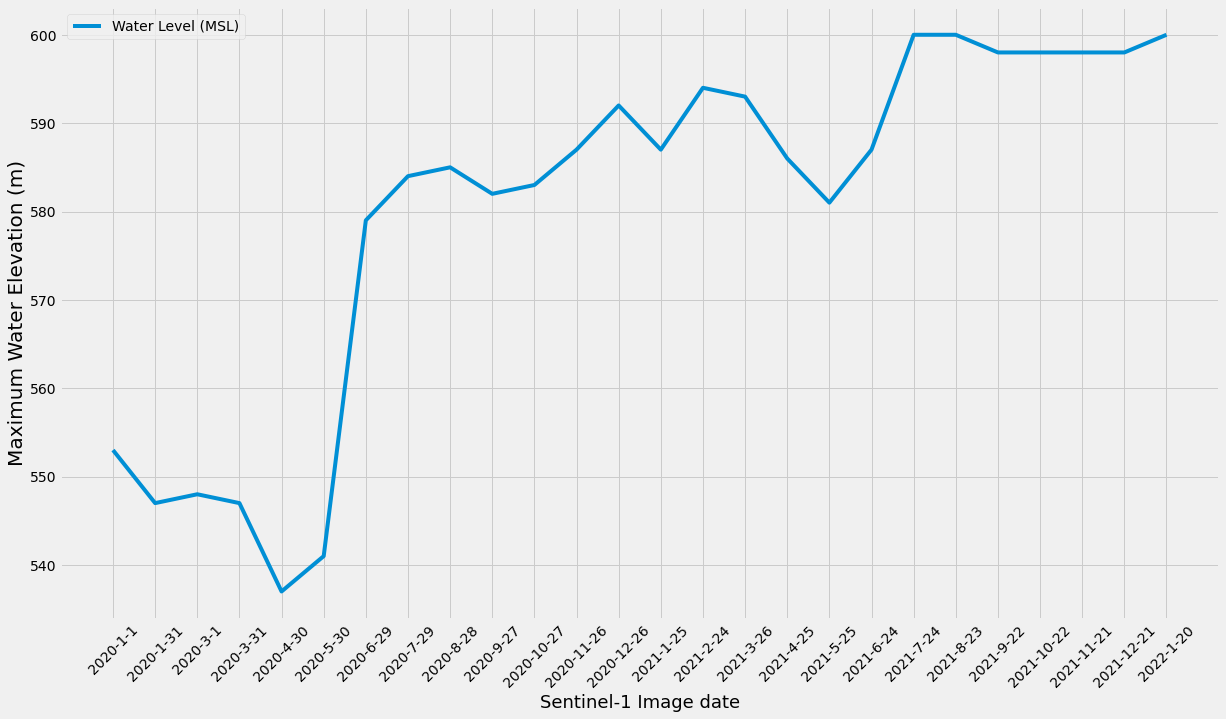

In [179]:
plt.style.use('fivethirtyeight')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.xlabel('Sentinel-1 Image date',fontsize=18)
plt.ylabel('Maximum Water Elevation (m)',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.plot(dates_list,max_elev, label = 'Water Level (MSL)')
plt.legend()
plt.gcf().set_size_inches(18.5,10.5)

In [180]:
def water_vol(lake_dem):
    
    elevations = lake_dem.reduceRegion(
        reducer=ee.Reducer.toList(), 
        geometry=lake_dem.geometry(),
        maxPixels=1e11,
        scale=30,
        crs = 'EPSG:32636',
        bestEffort = True
    ).get('DSM')
    
    elev_pixles_num = ee.List(elevations).length()
    
    elev_sum = ee.List(elevations).reduce(ee.Reducer.sum())
    
    stats = {'Pixels_number':elev_pixles_num,
             'Elevation_sum': elev_sum
            }
    
    return ee.Feature(None,stats)

In [181]:
volume_stats = dems.map(water_vol)

In [182]:
ele_sum = volume_stats.aggregate_array('Elevation_sum').getInfo()

In [183]:
pixel_num  = volume_stats.aggregate_array('Pixels_number').getInfo()

In [184]:
volume = [((water_level*pixles_count-elevations_sum)*900)/(1e9) for water_level,elevations_sum , pixles_count in zip(max_elev,ele_sum,pixel_num)]
    

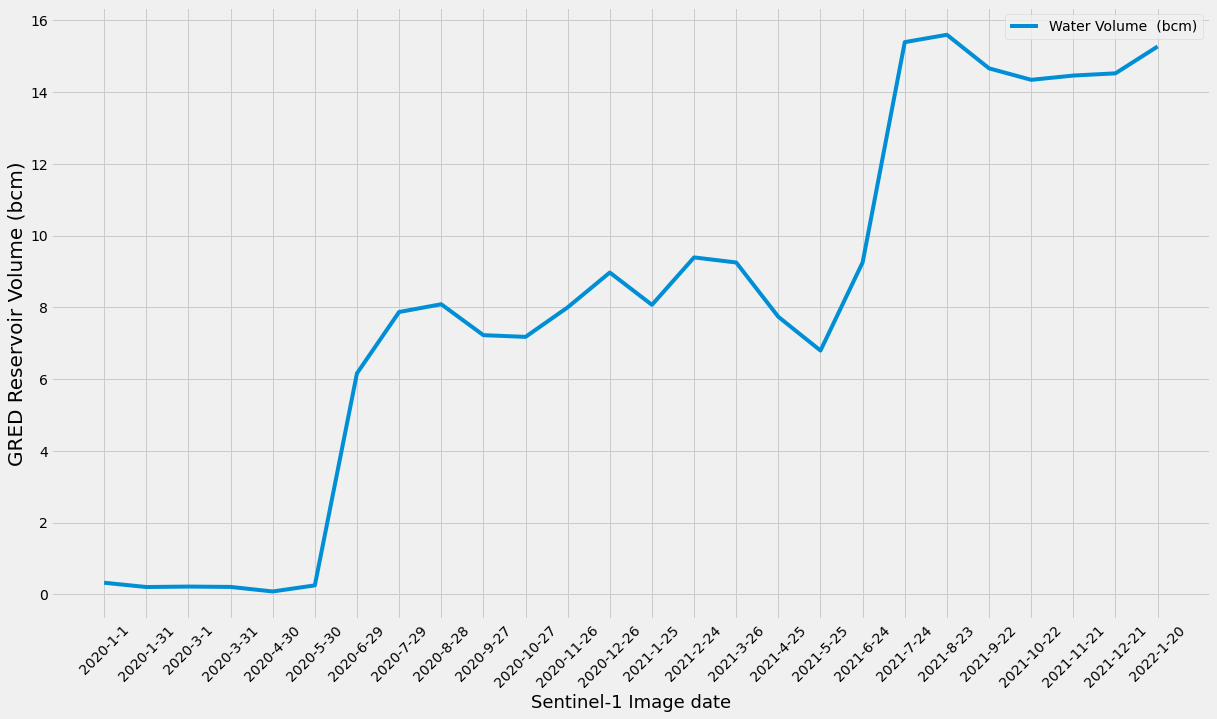

In [185]:
plt.style.use('fivethirtyeight')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.xlabel('Sentinel-1 Image date',fontsize=18)
plt.ylabel('GRED Reservoir Volume (bcm)',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.plot(dates_list,volume,label = 'Water Volume  (bcm)')
plt.legend()
plt.gcf().set_size_inches(18.5,10.5)